# Imports 

In [1]:
# %% Imports y configuración
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Agregar el directorio raíz al path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))

from model_dpm.simulations.sim_mixture import multimodal_mixture_sampler
from model_dpm.utils.sistem_fun import load_config, get_data_path, get_report_path
from model_dpm.models.kernel_laplace_v1 import DPMLaplace
from model_dpm.graphics.density import plot_density_estimation
from model_dpm.graphics.diagnostic import plot_cluster_assignment, plot_cluster_densities, plot_traces
from model_dpm.graphics.app_1 import plot_density_credible_interval

# Configuracion

In [2]:
# %% Parámetros de ejecución
NOMBRE_EJECUCION = "kernel_laplace_005"
SIM_REAL = "simulation"
CARACTERISTICAS = "Prueba del modelo DPM con kernel laplace - datos simulados con mixture de Laplace y Normal mas agresivo"

print(f"📊 Ejecución: {NOMBRE_EJECUCION}")
print(f"📁 Tipo: {SIM_REAL}")
print(f"📝 Notas: {CARACTERISTICAS}")

# Cargar configuración
config = load_config()

📊 Ejecución: kernel_laplace_005
📁 Tipo: simulation
📝 Notas: Prueba del modelo DPM con kernel laplace - datos simulados con mixture de Laplace y Normal mas agresivo


# Simulacion 

In [3]:
##################################################
# Simulacion o data real
##################################################

# Definir los parámetros de cada componente
components = [
    {'type': 'laplace', 'loc': -3, 'scale': 0.5, 'size': 100},
    {'type': 'laplace', 'loc': 10, 'scale': 0.5, 'size': 200},
    {'type': 'normal', 'loc': -10, 'scale': 0.8, 'size': 80},
    {'type': 'normal', 'loc': 3, 'scale': 0.8, 'size': 130}
]

print("\n🎲 Generando datos simulados...")
datos_array  = multimodal_mixture_sampler(components)

print(f"✅ Datos generados: {len(datos_array)} observaciones")

# Convertir a DataFrame si es necesario
if isinstance(datos_array, np.ndarray):
    datos = pd.DataFrame({'value': datos_array})
else:
    datos = datos_array

print(f"✅ Datos generados: {len(datos)} observaciones")
print(f"📊 Estadísticas descriptivas:")
print(datos.describe())

##################################################
# Guardar datos 
##################################################
output_path = get_data_path(config, data_type=SIM_REAL, io_type="output")
output_path.mkdir(parents=True, exist_ok=True)

datos_file = output_path / f"{NOMBRE_EJECUCION}.csv"
datos.to_csv(datos_file, index=False)
print(f"\n💾 Datos guardados en: {datos_file}")


🎲 Generando datos simulados...
✅ Datos generados: 510 observaciones
✅ Datos generados: 510 observaciones
📊 Estadísticas descriptivas:
            value
count  510.000000
mean     2.536279
std      7.289732
min    -11.731243
25%     -2.914918
50%      3.203760
75%      9.794480
max     12.090556

💾 Datos guardados en: C:\Users\JuanFran\Desktop\git_tesis\model_dpm\data\simulaciones\kernel_laplace_005.csv


# DPM

In [4]:
##################################################
# Aplicar la clase del modelo
##################################################
# Inicializar 
print("\n🔧 Inicializando modelo DPM con kernel Laplace...")

# Crear instancia del modelo Laplace
model_laplace = DPMLaplace(
    y=datos['value'].values,
    H=20,                              # Truncamiento inicial
    M_prior=(2.0, 1.0),                # Prior para concentración M
    mu0_prior=(0.0, 100.0),            # Prior para μ₀
    kappa0_prior=(2.0, 1.0),           # Prior para κ₀
    a0_prior=(3.0, 1.0),               # Prior para a₀
    beta0_prior=(2.0, 1.0),            # Prior para β₀
    verbose=True
)

# Ajustar el modelo
print("🔄 Ajustando modelo Laplace con Slice Sampling...")
trace = model_laplace.run(iterations=400, burnin=50)

print("✅ Modelo Laplace ajustado exitosamente\n")



🔧 Inicializando modelo DPM con kernel Laplace...
🔄 Ajustando modelo Laplace con Slice Sampling...
Iter 100/400: K_eff=5, M=1.03, μ₀=-0.86, κ₀=0.08, a₀=1.17, β₀=8.97
  [Acc: μ=0.08, b=0.60, κ=0.78, a=0.70]
Iter 200/400: K_eff=6, M=1.23, μ₀=2.92, κ₀=0.01, a₀=1.14, β₀=3.10
  [Acc: μ=0.07, b=0.52, κ=0.74, a=0.90]
Iter 300/400: K_eff=7, M=0.68, μ₀=-0.59, κ₀=0.01, a₀=0.89, β₀=3.57
  [Acc: μ=0.10, b=0.70, κ=0.88, a=0.77]
Iter 400/400: K_eff=6, M=0.80, μ₀=1.34, κ₀=0.01, a₀=0.66, β₀=3.11
  [Acc: μ=0.06, b=0.58, κ=0.84, a=0.83]
✅ Modelo Laplace ajustado exitosamente



# Graficos 

In [6]:
##################################################
# Resultados exploratorios
##################################################

# Ultima asignación de la cadena
cluster_assignments = trace['z'][-1]

# Agregar al dataframe
datos['cluster'] = cluster_assignments

# Número de clusters efectivos
n_clusters = len(np.unique(cluster_assignments))
print(f"📈 Número de clusters encontrados: {n_clusters}")

print("\n📊 Distribución de observaciones por cluster:")
print(datos['cluster'].value_counts().sort_index())

# %% Estadísticas por cluster
print("\n📈 Estadísticas por cluster:")
cluster_stats = datos.groupby('cluster')['value'].agg(['mean', 'std', 'count'])
print(cluster_stats)

📈 Número de clusters encontrados: 6

📊 Distribución de observaciones por cluster:
cluster
0    119
1     80
2    101
3     11
4    195
6      4
Name: count, dtype: int64

📈 Estadísticas por cluster:
              mean       std  count
cluster                            
0         3.118837  0.985366    119
1       -10.065846  0.717205     80
2        -2.822467  0.832884    101
3         2.051728  0.399892     11
4         9.965247  0.617570    195
6        11.726326  0.063159      4



📊 Generando gráfico de densidad...
📊 Generando gráfico de asignación de clusters...
📊 Generando gráfico de densidades por cluster...
📊 Generando gráficos de trazas...


C:\Users\JuanFran\Desktop\git_tesis\model_dpm\model_dpm\graphics\diagnostic.py:218: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\JuanFran\Desktop\git_tesis\model_dpm\model_dpm\graphics\diagnostic.py:221: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.savefig(save_path, dpi=300, bbox_inches='tight')
c:\Users\JuanFran\anaconda3\envs\model_dpm\Lib\site-packages\IPython\core\events.py:96: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  func(*args, **kwargs)


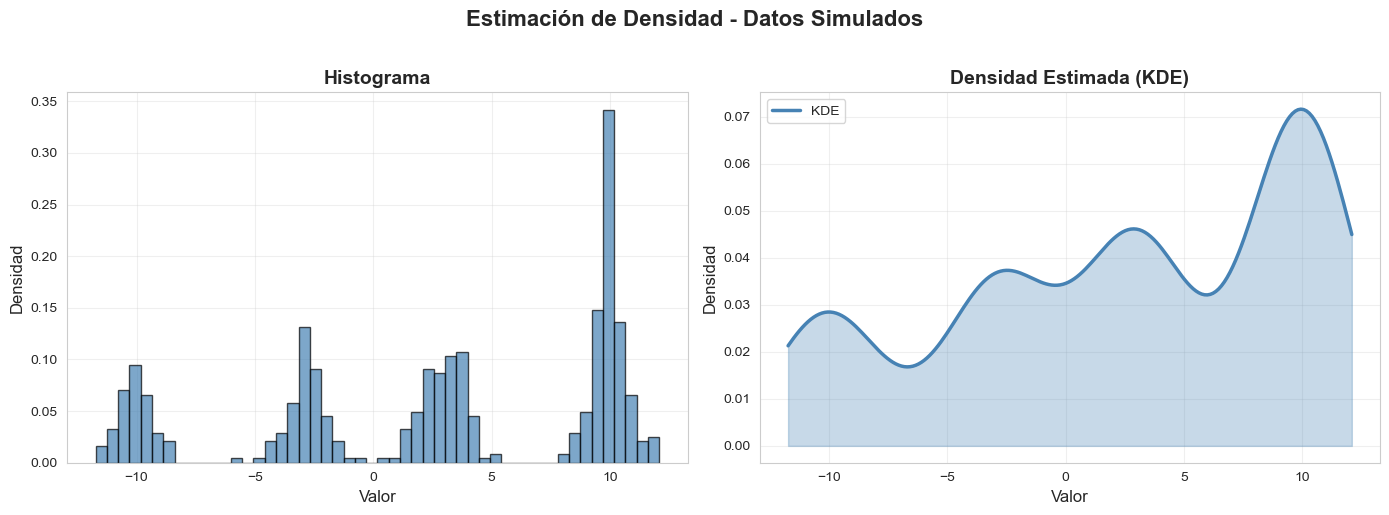

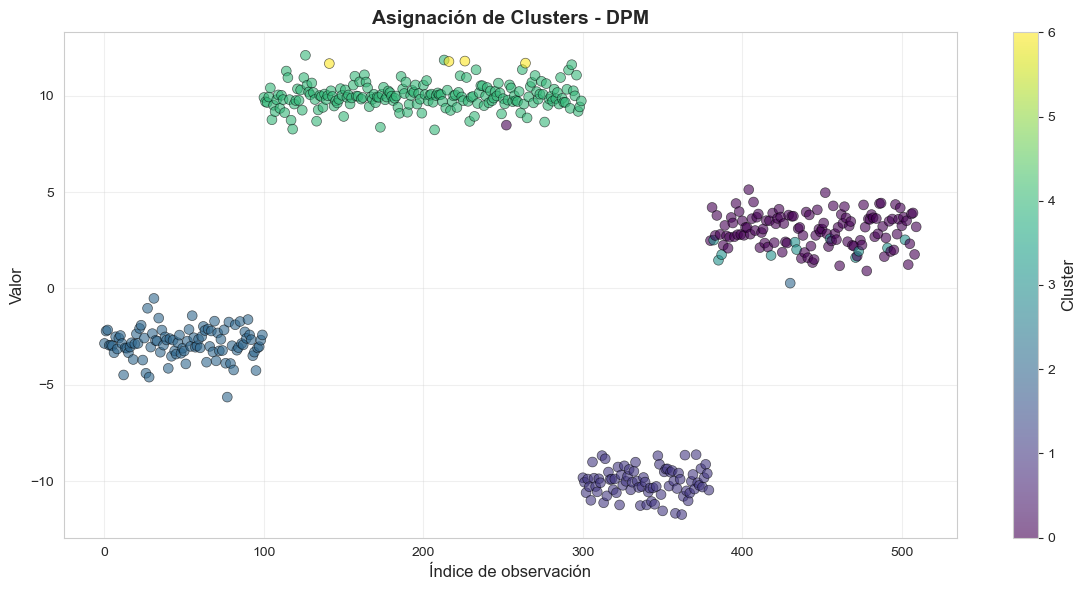

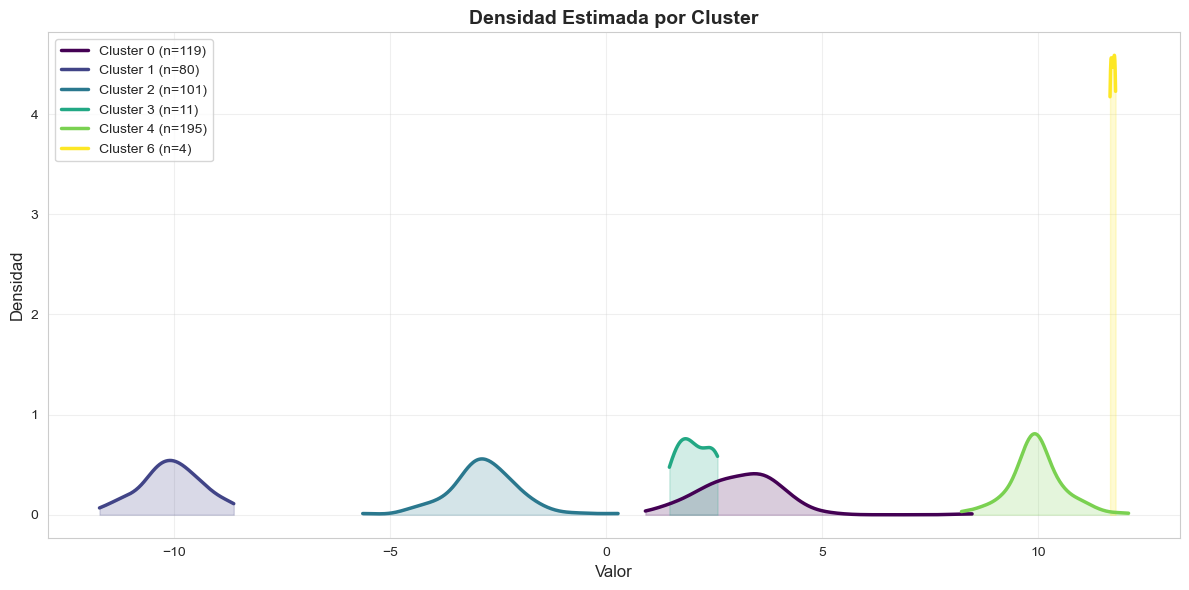

c:\Users\JuanFran\anaconda3\envs\model_dpm\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


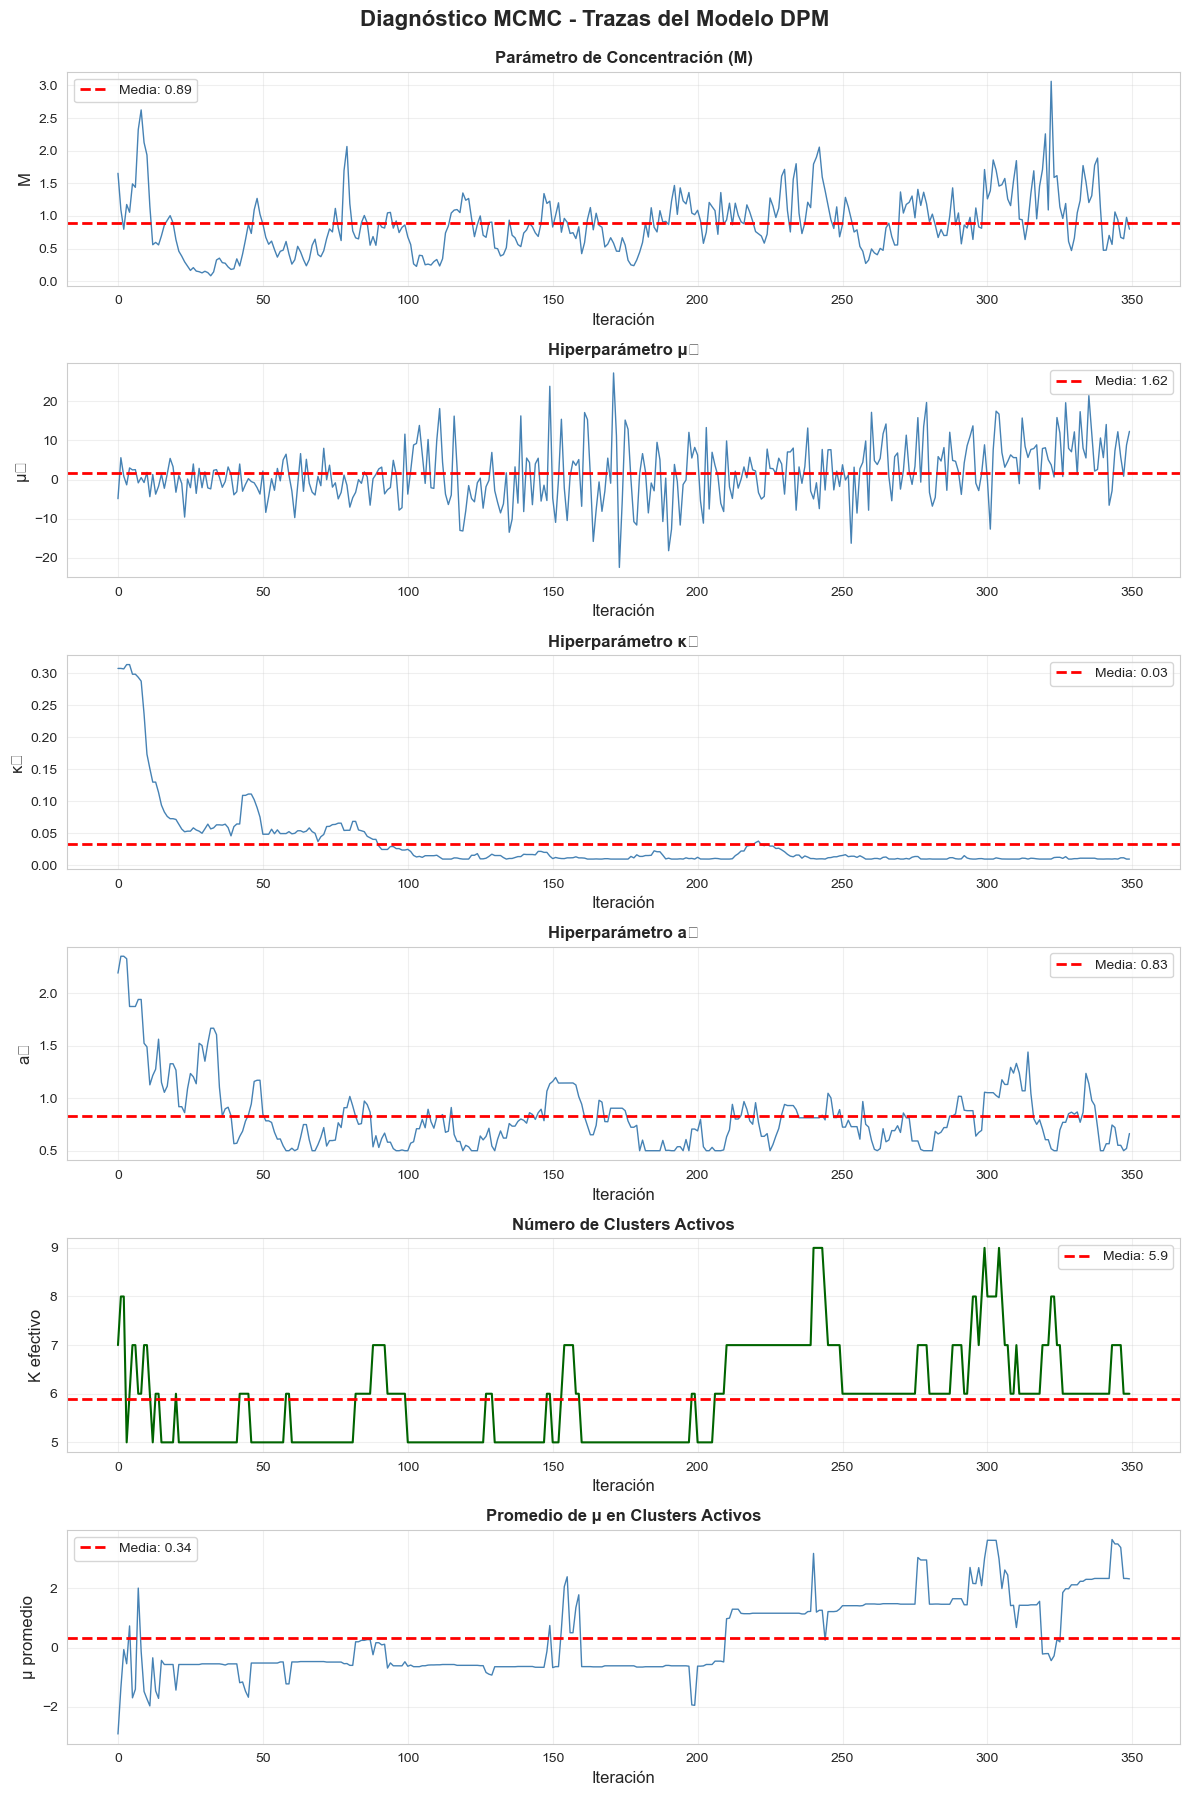

In [7]:
##################################################
# Graficos de diagnostico y analisis
##################################################

# %% 1. Gráfico de Densidad Estimada (Histograma + KDE)
print("\n📊 Generando gráfico de densidad...")
graphics_base_path = get_report_path(config, data_type=SIM_REAL, report_type="graphics")
graphics_path = graphics_base_path / NOMBRE_EJECUCION  # Subcarpeta con nombre de ejecución
graphics_path.mkdir(parents=True, exist_ok=True)

fig1 = plot_density_estimation(
    data=datos['value'].values,
    bins=50,
    title="Estimación de Densidad - Datos Simulados",
    save_path=graphics_path / "density.png"
)

# %% 2. Gráfico de Asignación de Clusters
print("📊 Generando gráfico de asignación de clusters...")
fig2 = plot_cluster_assignment(
    data=datos['value'].values,
    clusters=datos['cluster'].values,
    title="Asignación de Clusters - DPM",
    save_path=graphics_path / "clusters_assignment.png"
)

# %% 3. Gráfico de Densidades por Cluster
print("📊 Generando gráfico de densidades por cluster...")
fig3 = plot_cluster_densities(
    data=datos['value'].values,
    clusters=datos['cluster'].values,
    title="Densidad Estimada por Cluster",
    save_path=graphics_path / "clusters_densities.png"
)

# %% 4. Gráfico de Trazas (Diagnóstico MCMC)
print("📊 Generando gráficos de trazas...")
fig4 = plot_traces(
    trace=trace,
    burn_in=0,  # Ya aplicamos burnin en el modelo
    title="Diagnóstico MCMC - Trazas del Modelo DPM",
    save_path=graphics_path / "traces.png"
)

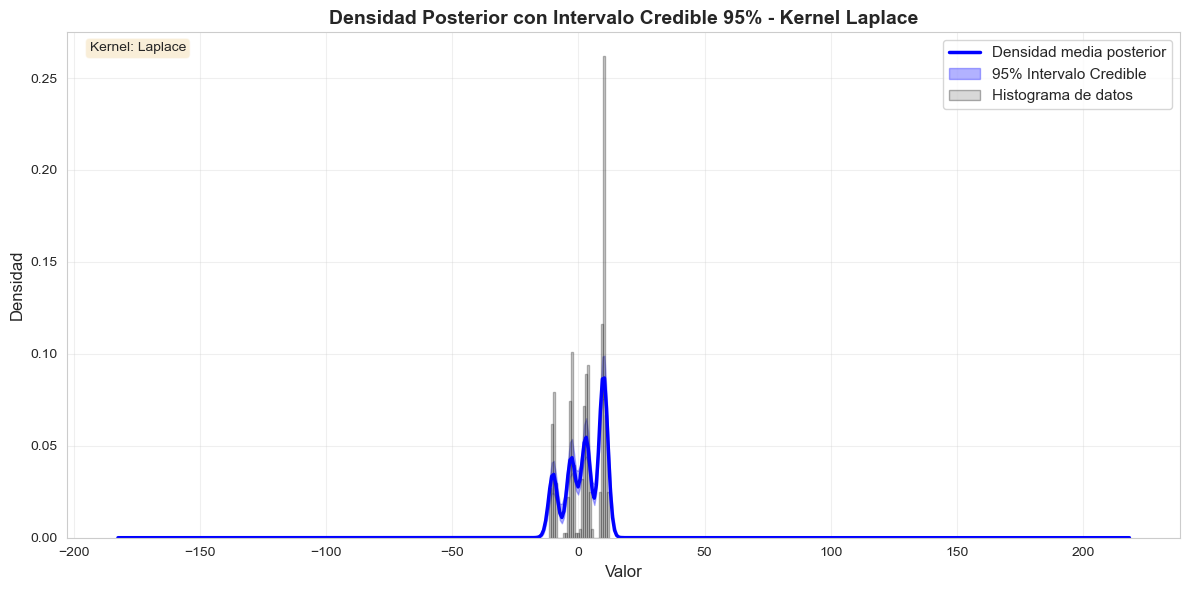

In [8]:
##################################################
# Graficos de intervalo de credibilidad 
##################################################
fig5_laplace = plot_density_credible_interval(
    trace=trace,
    y_data=datos['value'].values,
    kernel='laplace',
    burn_in=0,  # Ya aplicamos burnin
    n_posterior=2000,
    title="Densidad Posterior con Intervalo Credible 95% - Kernel Laplace",
    save_path=graphics_path / "credible_interval_laplace.png"
)